In [1]:
from qiskit_algorithms.utils import algorithm_globals
from sklearn import datasets
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, ZFeatureMap, TwoLocal
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from sklearn.svm import SVC
from qiskit_machine_learning.algorithms import QSVC
import numpy as np
from matplotlib import pyplot as plt
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import BlueprintCircuit
from qiskit.circuit import ParameterVector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

Create Iris training set and test set. Use 2 features and 2 classes to visualize better. 

In [9]:
algorithm_globals.random_seed = 13

#select which class and features to use
class1 = 0
class2 = 2
feature1 = 0
feature2 = 3

iris = datasets.load_iris()

X = iris.data[:, [feature1, feature2]]
y = iris.target

X = X[np.logical_or(y == class1, y == class2)]
y = y[np.logical_or(y == class1, y == class2)]

feature_dimension = X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=10, test_size=3, random_state=14)

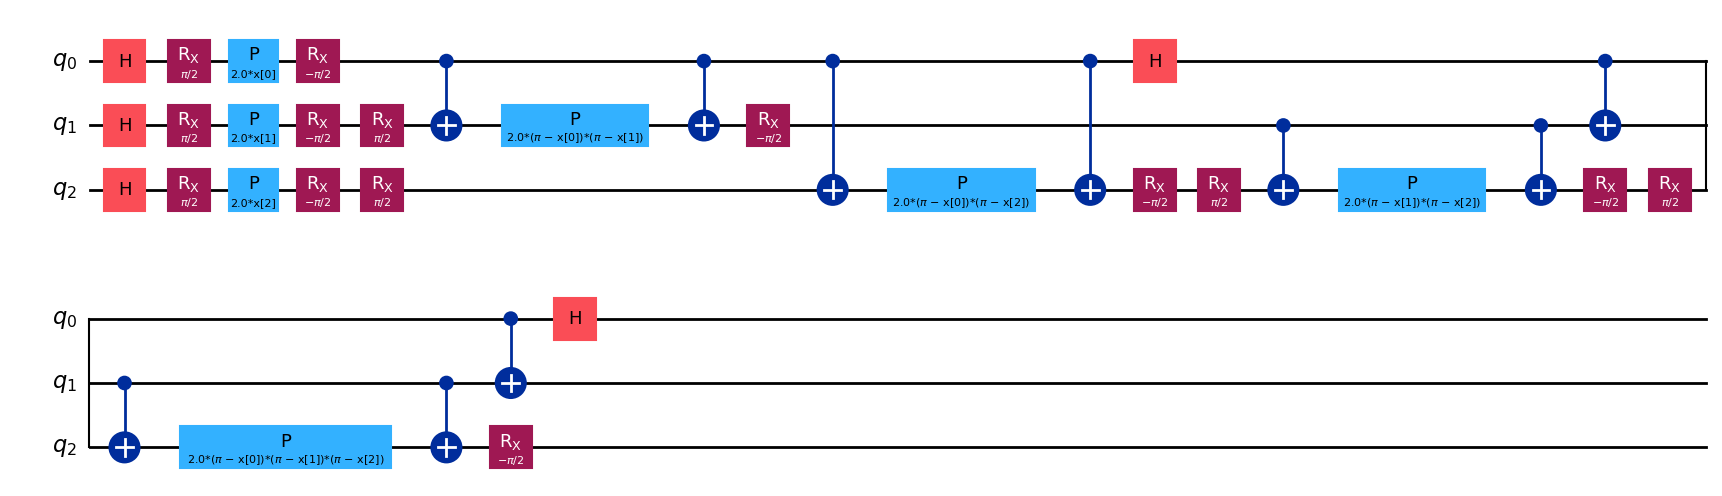

In [10]:
feature_map= PauliFeatureMap(feature_dimension=3, reps=1, paulis=["Y", "YZ"], entanglement="full")
feature_map.decompose().draw('mpl')

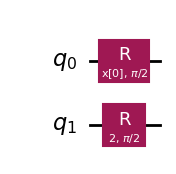

In [18]:
training_params = ParameterVector("x", 2)
feature_map = QuantumCircuit(2)
feature_map.ry(training_params[0], 0)
#feature_map.ry(training_params[1], 1)
feature_map.ry(2, 1)
feature_map.decompose().draw('mpl')

In [20]:
#create quantum kernel
kernel = FidelityQuantumKernel(feature_map=feature_map)

In [24]:
#fit classical SVM
svm = SVC(kernel=kernel.evaluate, C=1) 
svm.fit(X_train[:,:1],y_train)

print('Accuracy: ', svm.score(X_test[:,:1], y_test))

#plot decision boundary
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max, 0.5))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='binary')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, edgecolor='k')
plt.xlabel(f'Feature {feature1+1}')
plt.ylabel(f'Feature {feature2+1}')
plt.title('Test set')
plt.show()

Accuracy:  1.0


ValueError: x_vec and y_vec have incompatible dimensions.
x_vec has 2 dimensions, but y_vec has 1.